# OpenCV Eigenfaces for Face Recognition

In this tutorial, you will learn how to implement face recognition using the Eigenfaces algorithm, OpenCV, and scikit-learn.

## Eigenfaces, Principal Component Analysis (PCA), and face recognition

Fundamentals of the Eigenfaces algorithm were first presented by Sirovich and Kirby in their 1987 paper, Low-Dimensional Procedure for the Characterization of Human Faces, and then later formalized by Turk and Pentland in their 1991 CVPR paper, Face Recognition Using Eigenfaces.

These papers are considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. We’ll be discussing the technical inner workings of Eigenfaces here today.

The first step in the Eigenfaces algorithm is to input a dataset of N face images:

<image src="images/eigenfaces_caltech_dataset_with_names-768x286.jpeg">

Let’s now consider an image containing a face:

<image src="images/eigenfaces_face_dims.png">

When applying Eigenfaces, each face is represented as a grayscale, K×K bitmap of pixels (images do not have to be square, but for the sake of this example, it’s easier to explain if we assume square images).

In order to apply the Eigenfaces algorithm, we need to form a single vector from the image. This is accomplished by “flattening” each image into a $K^{2}$-dim vector:

<image src="images/eigenfaces_face_flatten.png">

Again, all we have done here is taken a K×K image and concatenated all of the rows together, forming a single, long $K^{2}$ list of grayscale pixel intensities.

After each image in the dataset has been flattened, we form a matrix of flattened images like this, where Z is the total number of images in our dataset:

<image src="images/eigenfaces_image_matrix.png">

Our entire dataset is now contained in a single matrix, M.

Given this matrix M, we are now ready to apply Principal Component Analysis (PCA), the cornerstone of the Eigenfaces algorithm.

A complete review associated with the linear algebra underlying PCA is outside the scope of this lesson (for a detailed review of the algorithm, please see Andrew Ng’s discussion on the topic), but the general outline of the algorithm follows:

1. Compute the mean $\mu_{i}$ of each column in the matrix, giving us the average pixel intensity value for every (x, y)-coordinate in the image dataset.
2. Subtract the $\mu_{i}$ from each column $c_{i}$ — this is called mean centering the data and is a required step when performing PCA.
3. Now that our matrix M has been mean centered, compute the covariance matrix.
4. Perform an eigenvalue decomposition on the covariance matrix to get the eigenvalues $\lambda_{i}$ and eigenvectors $\mathbf{X_{i}}$.
5. Sort $\mathbf{X_{i}}$ by $|\lambda_{i}|$, largest to smallest.
6. Take the top N eigenvectors with the largest corresponding eigenvalue magnitude.
7. Transform the input data by projecting (i.e., taking the dot product) it onto the space created by the top N eigenvectors — these eigenvectors are called our eigenfaces.

However, before we perform actual face identification using the Eigenfaces algorithm, let’s actually discuss these eigenface representations:

<image src="images/eigenfaces_decomp_matrix.png">

Each row in the matrix above is an eigenface with K^{2} entries — exactly like our original image

What does this mean? Well, since each of these eigenface representations is actually a K^{2} vector, we can reshape it into a K×K bitmap:

<image src="images/eigenfaces_mean_and_components.png">

The image on the left is simply the average of all faces in our dataset, while the figures on the right show the most prominent deviations from the mean in our face dataset.

This can be thought of as a visualization of the dimension in which people’s faces vary the most. Lighter regions correspond to higher variation, where darker regions correspond to little to no variation. Here, we can see that our eigenface representation captures considerable variance in the eyes, hair, nose, lips, and cheek structure.

Now that we understand how the Eigenfaces representation is constructed, let’s move on to learning how we can actually identify faces using Eigenfaces.

## Identifying faces using Eigenfaces

Given our eigenface vectors, we can represent a new face by taking the dot product between the (flattened) input face image and the N eigenfaces. This allows us to represent each face as a linear combination of principal components:

Query Face = 36% of Eigenface #1 + -8% of Eigenface #2 + … + 21% of Eigenface N

To perform the actual face identification, Sirovich and Kirby proposed taking the Euclidean distance between projected eigenface representations — this is, in essence, a k-NN classifier:

<image src="images/eigenfaces_face_distances.png">

The smaller the Euclidean distance (denoted as the function, d), the more “similar” the two faces are — the overall identification is found by taking the label associated with the face with the smallest Euclidean distance.

For example, in Figure 7 the top image pair has a distance of 0 because the two faces are identical (i.e., the same image).

The middle image pair has a distance of 0.07 — while the images are different they contain the same face.

The third image pair has a much larger distance (9.81), indicating that the two faces presented to the Eigenfaces algorithm are not the same person.

In practice, we often don’t rely on a simple k-NN algorithm for identification. Accuracy can be increased by using more advanced machine learning algorithms, such as Support Vector Machines (SVMs), Random Forests, etc. The implementation covered here today will utilize SVMs.

### Import Packages

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.exposure import rescale_intensity
from pyimagesearch.faces import load_face_dataset
from matplotlib import pyplot as plt
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import imutils
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing face detection and CALTECH face dataset loading

The CALTECH Faces challenge is a benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions, as seen in Figure 9.

The overall goal of this tutorial is to apply the Eigenfaces face recognition algorithm to identify each of the subjects in the CALTECH Faces dataset.

In [4]:
def detect_faces(net, image, minConfidence=0.5):
	# grab the dimensions of the image and then construct a blob
	# from it
	(h, w) = image.shape[:2]
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network to obtain the face detections,
	# then initialize a list to store the predicted bounding boxes
	net.setInput(blob)
	detections = net.forward()
	boxes = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > minConfidence:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# update our bounding box results list
			boxes.append((startX, startY, endX, endY))

	# return the face detection bounding boxes
	return boxes

In [5]:
def load_face_dataset(inputPath, net, minConfidence=0.5,
	minSamples=15):
	# grab the paths to all images in our input directory, extract
	# the name of the person (i.e., class label) from the directory
	# structure, and count the number of example images we have per
	# face
	imagePaths = list(paths.list_images(inputPath))
	names = [p.split(os.path.sep)[-2] for p in imagePaths]
	(names, counts) = np.unique(names, return_counts=True)
	names = names.tolist()

	# initialize lists to store our extracted faces and associated
	# labels
	faces = []
	labels = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image from disk and extract the name of the person
		# from the subdirectory structure
		image = cv2.imread(imagePath)
		name = imagePath.split(os.path.sep)[-2]

		# only process images that have a sufficient number of
		# examples belonging to the class
		if counts[names.index(name)] < minSamples:
			continue

		# perform face detection
		boxes = detect_faces(net, image, minConfidence)

		# loop over the bounding boxes
		for (startX, startY, endX, endY) in boxes:
			# extract the face ROI, resize it, and convert it to
			# grayscale
			faceROI = image[startY:endY, startX:endX]
			faceROI = cv2.resize(faceROI, (47, 62))
			faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

			# update our faces and labels lists
			faces.append(faceROI)
			labels.append(name)

	# convert our faces and labels lists to NumPy arrays
	faces = np.array(faces)
	labels = np.array(labels)

	# return a 2-tuple of the faces and labels
	return (faces, labels)

### Implementing Eigenfaces with OpenCV

In [6]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--input", type=str, required=True,
#	help="path to input directory of images")
#ap.add_argument("-f", "--face", type=str,
#	default="face_detector",
#	help="path to face detector model directory")
#ap.add_argument("-c", "--confidence", type=float, default=0.5,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-n", "--num-components", type=int, default=150,
#	help="# of principal components")
#ap.add_argument("-v", "--visualize", type=int, default=-1,
#	help="whether or not PCA components should be visualized")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "datasets/caltech_faces",
    "face": "pyimagesearch/face_detector",
    "confidence": 0.5,
    "num_components": 150,
    "visualize": 1
}

In [7]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


In [8]:
# load the CALTECH faces dataset
print("[INFO] loading dataset...")
(faces, labels) = load_face_dataset(args["input"], net,
	minConfidence=0.5, minSamples=20)
print("[INFO] {} images in dataset".format(len(faces)))

# flatten all 2D faces into a 1D list of pixel intensities
pcaFaces = np.array([f.flatten() for f in faces])

# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# construct our training and testing split
split = train_test_split(faces, pcaFaces, labels, test_size=0.25,
	stratify=labels, random_state=42)
(origTrain, origTest, trainX, testX, trainY, testY) = split

[INFO] loading dataset...
[INFO] 397 images in dataset


Here, we indicate N, the number of principal components we are going to use when initializing the PCA class. After we have found the top --num-components, we then use them to project the original training data to the Eigenface subspace.

In [9]:
# compute the PCA (eigenfaces) representation of the data, then
# project the training data onto the eigenfaces subspace
print("[INFO] creating eigenfaces...")
pca = PCA(
	svd_solver="randomized",
	n_components=args["num_components"],
	whiten=True)
start = time.time()
trainX = pca.fit_transform(trainX)
end = time.time()
print("[INFO] computing eigenfaces took {:.4f} seconds".format(
	end - start))

[INFO] creating eigenfaces...
[INFO] computing eigenfaces took 0.3460 seconds


From there, we loop over each of the top PCA components, reshape the image into a 47×62 pixel bitmap image , and then rescale the pixel intensities to the range $[0, 255]$.

Why do we bother with the rescaling operation?

Simple — our eigenvalue decomposition results in real-valued feature vectors, but in order to visualize images with OpenCV and cv2.imshow, our images must be unsigned 8-bit integers in the range $[0, 255]$.

The resulting component is then added to our list of images for visualization.

then we build a montage of the top components.

We then display the mean eigenvector representation in similar fashion on.

With visualization taken care of, let’s train our SVM on the eigenface representations:

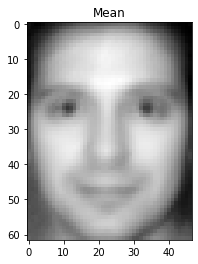

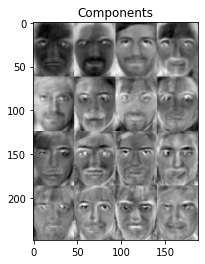

In [10]:
# check to see if the PCA components should be visualized
if args["visualize"] > 0:
	# initialize the list of images in the montage
	images = []

	# loop over the first 16 individual components
	for (i, component) in enumerate(pca.components_[:16]):
		# reshape the component to a 2D matrix, then convert the data
		# type to an unsigned 8-bit integer so it can be displayed
		# with OpenCV
		component = component.reshape((62, 47))
		component = rescale_intensity(component, out_range=(0, 255))
		component = np.dstack([component.astype("uint8")] * 3)
		images.append(component)

	# construct the montage for the images
	montage = build_montages(images, (47, 62), (4, 4))[0]

	# show the mean and principal component visualizations
	# show the mean image
	mean = pca.mean_.reshape((62, 47))
	mean = rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
	plt_imshow("Mean", mean)
	plt_imshow("Components", montage)

In [ ]:
initialize our SVM and train it.

We then use the model to make predictions on our testing data, taking care to project the testing data onto the eigenvalue subspace before making predictions.

This projection is a requirement. If you forget to perform the projection, one of two things will happen:

1. Your code will error out (due to a dimensionality mismatch between the feature vectors and the SVM model)
2. The SVM will return nonsense classifications (because the data the model was trained on was projected onto the eigenfaces representation)

Show a classification report, displaying the accuracy of our Eigenfaces recognition model.

The final step is to sample our testing data, make predictions on it, and display the results individually to our screen:

In [11]:
# train a classifier on the eigenfaces representation
print("[INFO] training classifier...")
model = SVC(kernel="rbf", C=10.0, gamma=0.001, random_state=42)
model.fit(trainX, trainY)

# evaluate the model
print("[INFO] evaluating model...")
predictions = model.predict(pca.transform(testX))
print(classification_report(testY, predictions,
	target_names=le.classes_))

[INFO] training classifier...
[INFO] evaluating model...
              precision    recall  f1-score   support

     abraham       1.00      1.00      1.00         5
       allen       1.00      1.00      1.00         8
      carmen       1.00      0.80      0.89         5
      conrad       0.75      1.00      0.86         6
     cynthia       1.00      1.00      1.00         5
     darrell       1.00      1.00      1.00         5
       frank       0.83      1.00      0.91         5
      gloria       1.00      1.00      1.00         5
     jacques       0.86      1.00      0.92         6
        judy       1.00      1.00      1.00         5
       julie       1.00      0.80      0.89         5
     kenneth       1.00      0.83      0.91         6
         mae       1.00      1.00      1.00         5
     raymond       1.00      1.00      1.00         6
        rick       1.00      1.00      1.00         6
      sherry       1.00      0.83      0.91         6
     tiffany       1.00 

[INFO] prediction: allen, actual: allen


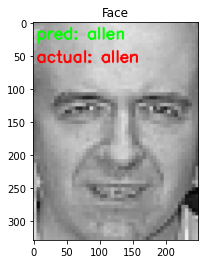

[INFO] prediction: julie, actual: julie


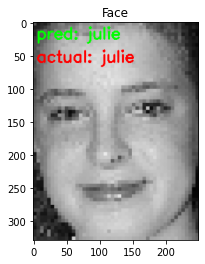

[INFO] prediction: willie, actual: willie


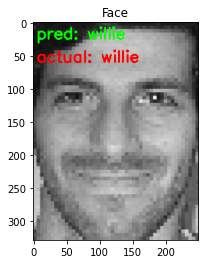

[INFO] prediction: frank, actual: frank


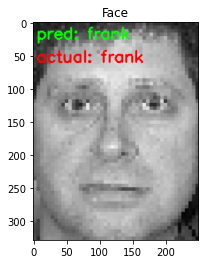

[INFO] prediction: judy, actual: judy


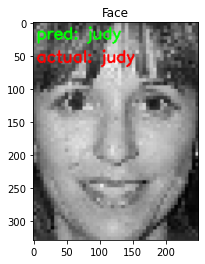

[INFO] prediction: carmen, actual: carmen


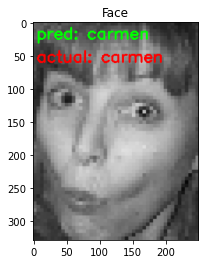

[INFO] prediction: conrad, actual: conrad


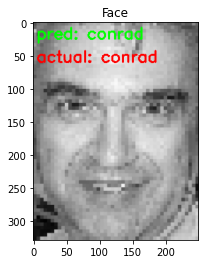

[INFO] prediction: tiffany, actual: tiffany


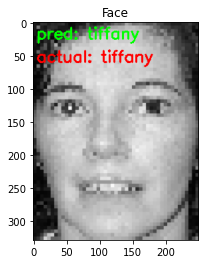

[INFO] prediction: abraham, actual: abraham


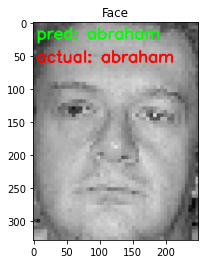

[INFO] prediction: gloria, actual: gloria


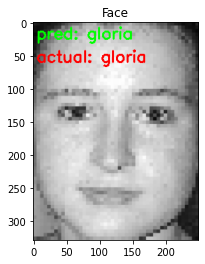

In [12]:
# generate a sample of testing data
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)

# loop over a sample of the testing data
for i in idxs:
	# grab the predicted name and actual name
	predName = le.inverse_transform([predictions[i]])[0]
	actualName = le.classes_[testY[i]]

	# grab the face image and resize it such that we can easily see
	# it on our screen
	face = np.dstack([origTest[i]] * 3)
	face = imutils.resize(face, width=250)

	# draw the predicted name and actual name on the image
	cv2.putText(face, "pred: {}".format(predName), (5, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
	cv2.putText(face, "actual: {}".format(actualName), (5, 60),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

	# display the predicted name  and actual name
	print("[INFO] prediction: {}, actual: {}".format(
		predName, actualName))

	# display the current face to our screen
	plt_imshow("Face", face)

## Problems with Eigenfaces for face recognition
One of the biggest criticisms of the Eigenfaces algorithm is the strict facial alignment required when training and identifying faces:

Since we are operating at the pixel level, facial features such as eyes, nose, and mouth need to be aligned near perfectly for all images in our dataset. Not only is this a challenging task, it can be very hard to guarantee in real-world situations where conditions are less than ideal.

In our case, most faces in the CALTECH Faces dataset were captured from a frontal view with no viewpoint change, head tilt, etc. Due to this face we didn’t need to explicitly apply face alignment and everything worked out in our favor; however, it’s worth noting that this situation rarely happens in real-world conditions.

